In [23]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import xgboost as xgb
from xgboost import plot_importance

## Reading in Data

In [3]:
x_train = pd.read_csv(
  "../data/processed/x_train_w_OHE.csv", index_col=0, dtype=str
)
x_test = pd.read_csv(
  "../data/processed/x_test_w_OHE.csv", index_col=0, dtype=str
)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

In [4]:
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]

In [5]:
#Scale all numeric columns then add back in zip columns
zip_cols = x_train.columns[
    [re.search('zip_is', col) is not None for col in x_train.columns]
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_valid = get_correct_types_x(x_valid, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_valid = x_valid[numeric_cols]
rel_x_test = x_test[numeric_cols]

scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_x_train = np.hstack([
    scaler.transform(rel_x_train), np.array(x_train[zip_cols])
])
scaled_x_valid = np.hstack([
    scaler.transform(rel_x_valid), np.array(x_valid[zip_cols])
])
scaled_x_test = np.hstack([
    scaler.transform(rel_x_test), np.array(x_test[zip_cols])
])

## Baseline Model

In [6]:
baseline_params = {'max_depth':6, 'eta':.3, 'objective':'reg:squarederror'}
num_round = 5
baseline_d_train = xgb.DMatrix(scaled_x_train, label = y_train)
xgb_model = xgb.train(baseline_params, baseline_d_train, num_round)
d_test = xgb.DMatrix(scaled_x_test, label = y_test)
baseline_preds = xgb_model.predict(d_test)
print("RMSE = ", np.sqrt(mean_squared_error(baseline_preds, y_test)))

RMSE =  1070.4475962877377


## Optimizing Hyperparameters

In [7]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 550),
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 11),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBRegressor(**params)
    optuna_model.fit(scaled_x_train, y_train)

    # Make predictions
    y_valid_pred = optuna_model.predict(scaled_x_valid)

    # Evaluate predictions
    accuracy = np.sqrt(mean_squared_error(y_valid_pred, y_valid))
    return accuracy

In [8]:
sampler = TPESampler(seed=24)
study = optuna.create_study(sampler=sampler, direction='minimize')

[I 2022-12-01 13:49:13,958] A new study created in memory with name: no-name-5c31bb00-638e-4583-8319-1b17bdc7680a


In [9]:
study.optimize(objective, n_trials=100)
warnings.filterwarnings('ignore')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  RMSE: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

/var/folders/0t/1nvk44m92fs3tyhh0yhghlmm0000gn/T/ipykernel_53220/1111999842.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/0t/1nvk44m92fs3tyhh0yhghlmm0000gn/T/ipykernel_53220/1111999842.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/0t/1nvk44m92fs3tyhh0yhghlmm0000gn/T/ipykernel_53220/1111999842.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial

Number of finished trials: 100
Best trial:
  RMSE: 696.0994199553038
  Params: 
    max_depth: 8
    learning_rate: 0.011592848172307444
    n_estimators: 541
    min_child_weight: 4
    gamma: 5.704592135237904e-06
    subsample: 0.6551854217446456
    colsample_bytree: 0.919958602737086
    reg_alpha: 0.9811197710000061
    reg_lambda: 0.025303068907866263


## Fit model with best parameters and predict

In [10]:
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return (
        1 - sse / sst, np.sqrt(sse / len(true_vals)),
        mean_absolute_error(pred_vals, true_vals)
    )

In [11]:
best_params = trial.params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(scaled_x_train, y_train)
final_preds = best_model.predict(scaled_x_test)
# print("RMSE = ", np.sqrt(mean_squared_error(final_preds, y_test)))
baseline_rmse = np.sqrt(((y_test - y_test.mean()) ** 2).mean())
test_r2, rmse, mae = calc_test_r2(final_preds, y_test, baseline_rmse)
print('Test R-Squared:', test_r2)
print('RMSE:', rmse)
print('MAE:', mae)

Test R-Squared: 0.7840977049573588
RMSE: 734.1466364065583
MAE: 497.71040169519324


In [13]:
np.savetxt('../data/predictions/xgboost_final_preds.csv', final_preds)

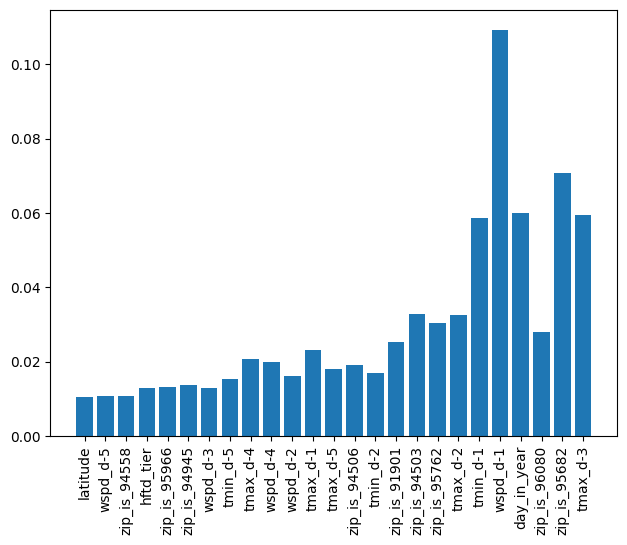

In [41]:
model_features  = np.concatenate((numeric_cols, zip_cols))
num_feat_imp = 25
#Extract indices of top num_feat_imp most important features
feature_indices = np.argpartition(best_model.feature_importances_, -num_feat_imp)[-num_feat_imp:]
# print(feature_indices)

fig, ax = plt.subplots()
plt.bar(model_features[feature_indices], best_model.feature_importances_[feature_indices])
fig.tight_layout()
plt.xticks(rotation=90)
plt.show()